# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait seul ou en binôme. Aucun groupe de plus de 2 personnes. 

Vous allez rendre le TP depuis un lien GitHub avec ce notebook mais une version du rapport exportée en PDF & HTML. 

In [1]:
! pip install matplotlib tqdm numpy ipympl opencv-python
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl.metadata (755 bytes)
Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)
(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(0)

K = 5 # num arms

# Présentation du problème

In [3]:
class ArmBernoulli:
    def __init__(self, p: float):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             
        >>> torch.random.manual_seed(random_state)        
        >>> arm = ArmBernoulli(0.5)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        self.immunity_rate = p

    def sample(self, n: int = 1):
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(K)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Créez une fonction pour trouver $\mu^*$ à partir d'un `MAB`. Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans le contexte de ce TP ?**

In [4]:
def get_mu_star(MAB):
    best_arm = max(MAB, key=lambda arm: arm.immunity_rate)
    return best_arm

mu_star = get_mu_star(MAB)
print("The best vaccine has an immunity rate of", mu_star.immunity_rate)

The best vaccine has an immunity rate of tensor(0.7682)


**Récompense Rk:** La récompense $R_k$ est obtenue selon si le patient est immunisé (1) ou non (0). Elle suit donc une loi de Bernoulli avec $P(R_k = 1) = p$ et $P(R_k = 0) = 1 - p$.


**Regret :** Le regret représente la différence entre la récompense obtenue si on utilisait le meilleur vaccin pour $N$ individus, et la récompense réelle obtenue en testant plusieurs vaccins.

Dans le contexte de ce TP : 
$ R_n = n \times (\text{Immunité du meilleur vaccin}) - \sum (\text{récompenses du vaccin } k) $
avec $k$ le vaccin déterminé dans la phase d'exploration.

**Note importante :** pour la suite, les résultats seront généralement réalisés avec 100 initialisations différentes du MAB (tous les MAB ont 5 vaccins mais des taux d'immunistation différent) pour réduire le bruit de simulation. Concrètement, on exécutera au moins 100x `generate_arms`.

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** Le médecin calcule le taux d'immunisation empirique sur les N premiers patients en administrant le même nombre de fois chaque vaccin :

$$\hat{\mu_i}[0\rightarrow N] = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \hat{\mu_j}[0\rightarrow N]$ est utilisé pour les M patients suivants.

**Q2. Implémentez cette solution avec N = 50 et M = 500 et testez-la avec 100 MAB. On souhaite savoir si vous trouvez le vaccin optimal à l'issue d'une phase d'exploration. Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [15]:
def exploration(N, rewards, T, MAB):
    for i in range(N):
        arm_index = i % num_arms
        rewards[arm_index] += MAB[arm_index].sample().float().item()
        T[arm_index] += 1
        
    empirical_means = rewards / np.where(T != 0, T, 1) # Avoid dividing by 0
    return np.argmax(empirical_means), empirical_means, rewards


def exploitation(M, best_arm, MAB):
    return MAB[best_arm].sample(M).tolist()

def explore_and_exploit(N, M, optimal_reward, MAB):
    rewards = np.zeros(num_arms)
    T = np.zeros(num_arms) 

    best_arm, empirical_means, rewards = exploration(N, rewards, T, MAB)
    exploitation_samples = exploitation(M, best_arm, MAB)
    
    regret = optimal_reward - (sum(rewards) + sum(exploitation_samples))
    return regret, best_arm


def simulation(N, M, nums_simulations = 100):
    regrets = []
    found_best_arm = []
    
    for i in range(nums_simulations):
        # Setup Simulation
        MAB = generate_arms(K)
        mu_star = get_mu_star(MAB)
        optimal_reward = (N + M) * mu_star.immunity_rate
        
        # Exploration and Exploitation
        regret, best_arm = explore_and_exploit(N, M, optimal_reward, MAB)
        
        # Storing the result
        regrets.append(regret)
        found_best_arm.append(MAB[best_arm].immunity_rate == mu_star.immunity_rate)
    
    return np.mean(found_best_arm), np.std(found_best_arm), np.mean(regrets), np.std(regrets)

K = 5
num_arms = len(MAB)
mean_chosen_vaccin, std_chosen_vaccin, mean_regret, std_regret = simulation(N=50, M=500)

print("Vaccin optimale")
print("Moyenne empirique:", mean_chosen_vaccin)
print("Ecart-Type", std_chosen_vaccin)

print()

print("Regret")
print("Esperance", mean_regret)
print("Ecart-Type", std_regret)

Vaccin optimale
Moyenne empirique: 0.76
Ecart-Type 0.4270831300812525

Regret
Esperance 26.20553
Ecart-Type 24.960636


**Q3. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

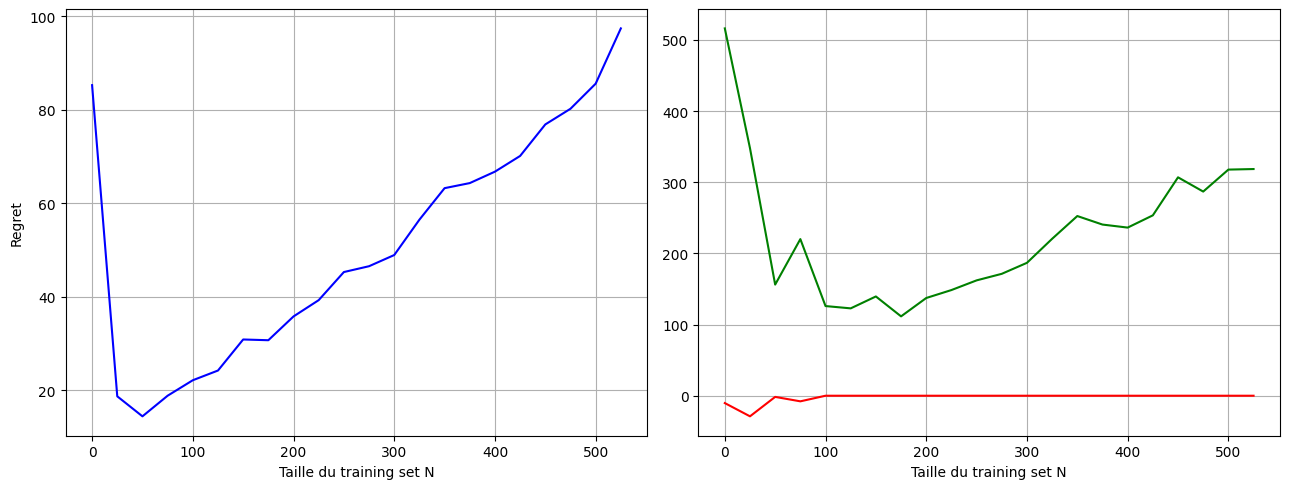

In [16]:
def analyze_exploration_impact(N_total, num_simulations=100):
    regrets = []
    
    for K in range(0, N_total, 25):  
        regret_simulations = []
        for _ in range(num_simulations):
            MAB = generate_arms(K)
            mu_star = get_mu_star(MAB)
            optimal_reward = (N_total) * mu_star.immunity_rate
            
            regret = explore_and_exploit(K, N_total - K, optimal_reward, MAB)
            
            regret_simulations.append(regret)
               
        regrets.append({
            'N': K,
            'mean_regret': np.mean(regret_simulations),
            'min_regret': np.min(regret_simulations),
            'max_regret': np.max(regret_simulations),
        })
    
    return regrets

def plot_regrets(regrets):
    Ns = [r['N'] for r in regrets]
    mean_regrets = [r['mean_regret'] for r in regrets]
    min_regrets = [r['min_regret'] for r in regrets]
    max_regrets = [r['max_regret'] for r in regrets]
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    
    # Regret
    axs[0].plot(Ns, mean_regrets, label='Regret moyen', color='blue')
    axs[0].set_xlabel('Taille du training set N')
    axs[0].set_ylabel('Regret')
    axs[0].grid(True)
    
    axs[1].plot(Ns, min_regrets, label='Regret minimal', color='red')
    axs[1].plot(Ns, max_regrets, label='Regret maximal', color='green')
    axs[1].set_xlabel('Taille du training set N')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


regrets = analyze_exploration_impact(550, 100)
plot_regrets(regrets)

La taille optimale du training set semble tourner au alentour de **50**. Comme indiqué la courbe est V. Le regret est très haut quand N est faible, cela s'explique par le fait que la phase d'exploration a été trop précipité et donc que la bonne variable n'a pas été trouver. A contrario, lorsque la taille du training Set augmente, le regret augmente aussi. Cette fois-ci, on passe trop de temps à explorer le bon vaccin mais du coup pas assez de temps à l'exploiter.

**Q4. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\hat{\mu}_i$ pendant la phase d'exploitation (algorithme *greedy*). Concrètement, à chaque nouvel patient, on lui administre le meilleur vaccin selon les stats. Notez vous une amélioration du regret ? Proposez un exemple où les taux d'immunisation du MAB ne changent rien.** 

In [17]:
def greedy_exploitation(M, best_arm, rewards, T, empirical_means, MAB ):
    total_reward = sum(rewards)
    for _ in range(M):
        best_arm = np.argmax(empirical_means)
        new_sample = MAB[best_arm].sample().float().item()
        rewards[best_arm] += new_sample
        T[best_arm] += 1
        empirical_means[best_arm] = rewards[best_arm] / T[best_arm]  # Mise à jour des stats
        total_reward += new_sample
        
    return total_reward

def explore_and_greedy_exploit(N, M, optimal_reward, MAB):
    rewards = np.zeros(num_arms)
    T = np.zeros(num_arms) 

    best_arm, empirical_means, rewards = exploration(N, rewards, T, MAB)
    
    total_reward = greedy_exploitation(M, best_arm, rewards, T, empirical_means, MAB)
    
    regret = optimal_reward - total_reward
    return regret


def greedy_simulation(N, M, nums_simulations = 100):
    regrets = []

    
    for i in range(nums_simulations):
        MAB = generate_arms(K)
        mu_star = get_mu_star(MAB)
        optimal_reward = (N + M) * mu_star.immunity_rate
        
        regret = explore_and_greedy_exploit(N, M, optimal_reward, MAB)
        regrets.append(regret)
    
    return np.mean(regrets), np.std(regrets)


mean_regret, std_regret = greedy_simulation(N=50, M=500)

print("Esperance du Regret", mean_regret)
print("Ecart-Type du regret", std_regret)

Esperance du Regret 21.775303
Ecart-Type du regret 14.715528


Dans notre version non-greedy, nous avions :

    Regret :
        Espérance : 37.08781
        Écart-type : 44.063488

On constate donc une réelle amélioration de l'espérance moyenne, ainsi qu'une diminution significative de l'écart-type. Cette méthode est donc plus efficace. Cependant, cette configuration peut ne rien changer si :

- Le vaccin optimal est trouvé dès la phase d'exploration (aucun intérêt de changer).
- Les vaccins ont des taux d'immunité quasi-similaires (équivalent à un classique).


**Q5. Nouvelle amélioration : à chaque nouveau patient, on choisit si on lui administre le meilleur vaccin avec une probabilité $\epsilon$ ou un vaccin aléatoire ($p=1-\epsilon$). Vérifiez si vous obtenez un meilleur résultat avec N = 0 ou N > 0. À votre avis, à quoi sert $\epsilon$ ?** 

In [18]:
def epsilon_greedy_exploitation(M, best_arm, rewards, T, empirical_means, MAB, epsilon):
    total_reward = sum(rewards)
    for _ in range(M):
        if np.random.rand() <= epsilon:  
            best_arm = np.argmax(empirical_means)
        else:  
             best_arm = np.random.choice(len(MAB))
        
        new_sample = MAB[best_arm].sample().float().item()
        rewards[best_arm] += new_sample
        T[best_arm] += 1
        empirical_means[best_arm] = rewards[best_arm] / T[best_arm]  # Mise à jour des stats
        total_reward += new_sample
        
    return total_reward

def explore_and_epsilon_greedy_exploit(N, M, optimal_reward, MAB, epsilon):
    rewards = np.zeros(num_arms)
    T = np.zeros(num_arms) 

    best_arm, empirical_means, rewards = exploration(N, rewards, T, MAB)
    total_reward = epsilon_greedy_exploitation(M, best_arm, rewards, T, empirical_means, MAB, epsilon)
    
    
    
    regret = optimal_reward - total_reward
    return regret


def epsilon_greedy_simulation(N, M, nums_simulations = 100, epsilon = 0.5):
    regrets = []

    
    for i in range(nums_simulations):
        
        MAB = generate_arms(K)
        mu_star = get_mu_star(MAB)
        optimal_reward = (N + M) * mu_star.immunity_rate
        
        regret = explore_and_epsilon_greedy_exploit(N, M, optimal_reward, MAB, epsilon)
        regrets.append(regret)
    
    return np.mean(regrets), np.std(regrets)


mean_regret, std_regret = greedy_simulation(N=50, M=500)
print("Pour N > 0:")
print("Esperance du Regret", mean_regret)
print("Ecart-Type du regret", std_regret)

print()

mean_regret, std_regret = epsilon_greedy_simulation(N=0, M=550)
print("Pour N = 0:")
print("Esperance du Regret", mean_regret)
print("Ecart-Type du regret", std_regret)


Pour N > 0:
Esperance du Regret 20.174423
Ecart-Type du regret 15.976085

Pour N = 0:
Esperance du Regret 91.27994
Ecart-Type du regret 31.932993


Lorsque N > 0, on constate une nette amélioration comparé à greedy-simulation. En revanche, ne pas avoir de face d'exploration semble compromettre la recherche du bon vaccin puisqu'on a une Esperance de 97. La question peut néanmoins dépendre de la valeur d'Epsilon.

Epsilon sert à rajouter de une itération d'exploration pendant l'exploitation. Et donc de tester avec plusieurs vaccin. Cela peut etre une tres bonne idée lorsqu'on que nous pensons avoir trouver le bon vaccin pendant l'exploration mais qu'en réalité non.

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Lai et Robbins [Lai et Robbins, 1985] considère une classe d'algorithmes $\pi$ pour résoudre ce type de problèmes.

Ils ont trouvé une borne inférieure sur les récompenses cumulées en valeur asymptotique :

$$\lim_{n\rightarrow \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients.
 
 
**Q6. Justifiez pourquoi on peut en déduire que le regret d'un algorithme raisonnable sera au pire logarithmique.**

Le regret correspond a la difference entre la recompense moyenne du meilleur vaccin et les recompenses obtenues pour K individus. On ajoutant cela a l'inequation de la borne inferieure de Lai et Robbins on se retrouve par un regret majoré par $n \mu^* - C(\mu) \log n$

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

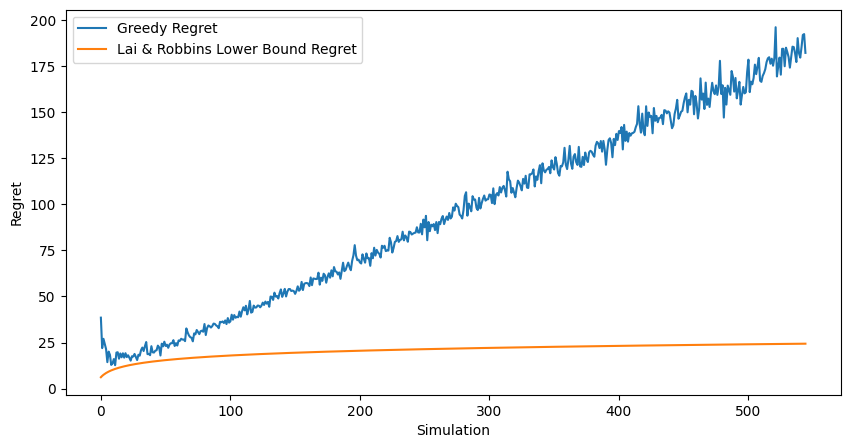

In [23]:
def KL(x, y):
    return x*np.log(x/y) + (1-x)*np.log((1-x)/(1-y))

def C(mus):
    c = 0
    mu_star = get_mu_star(MAB).immunity_rate

    for mu in mus:
        if mu == mu_star:
            continue
        c += (mu_star - mu) / KL(mu, mu_star)
    return c

def lai_robbins_lower_bound(n, mus):
    return C(mus) * np.log(n)

def compare_lai_robbins_greedy(N, M=50):
    regrets_greedy = []
    regrets_lai_robbins = []
    
    for k in range(5, N + M):
        mu_star = get_mu_star(MAB)
        optimal_reward = k * mu_star.immunity_rate
        
        # Greedy simulation
        mean_regret_greedy, std_regret_greedy = greedy_simulation(k, M)
        regrets_greedy.append(mean_regret_greedy)
        # Lai & Robbins lower bound
        mus = [arm.immunity_rate.item() for arm in MAB]
        regret_lai_robbins = lai_robbins_lower_bound(k, mus)
        regrets_lai_robbins.append(regret_lai_robbins)
    
    return regrets_greedy, regrets_lai_robbins

regrets_greedy, regrets_lai_robbins = compare_lai_robbins_greedy(N=50, M=500)

plt.figure(figsize=(10, 5))
plt.plot(regrets_greedy, label='Greedy Regret')
plt.plot(regrets_lai_robbins, label='Lai & Robbins Lower Bound Regret')
plt.xlabel('Simulation')
plt.ylabel('Regret')
plt.legend()
plt.show()


*[Ajoutez votre commentaire ici]*

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$$
\bar{\mu}_i = \hat{\mu}_i + \sqrt{\frac{C \log{n}}{T_i}}
$$

avec $C=2$.

**Q8. Implémentez la modification de cet algorithme. Observez un intérêt à conserver $N > 0$ ? Et $\epsilon < 1$ ? Expliquez pourquoi.**

Dans la suite, on prendra $N = 0$ et $\epsilon = 1$.


*[Ajoutez votre commentaire ici]*

**Q9. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez $\bar{\mu}_i$ et $\hat{\mu}_i$ pour chaque vaccin.**

*[Ajoutez votre commentaire ici]*

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

*[Ajoutez votre commentaire ici]*

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

*[Ajoutez votre commentaire ici]*

# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. En testant plusieurs valeurs de $N$, montrez que la phase d'exploration précédente a un impact très limité. Cela veut-il dire que l'algorithme ne contient pas d'initialisation ?**

In [5]:
class Beta:
    def __init__(self):
        self.immuned = 1
        self.non_immuned = 1

    def sample(self):
        return np.random.beta(self.immuned, self.non_immuned)
    
    def __repr__(self):
        return f'<Beta a={self.immuned}, b={self.non_immuned}' 


def thomson_sampling(N, M, nums_simulations=100):
    regrets = []
    for _ in range(nums_simulations):
        MAB = generate_arms(K)
        vacc_betas = [Beta() for _ in range(K)]
        rewards = 0
        # EXPLORATION
        for i in range(N):
            arm = i % K
            reward = MAB[arm].sample().item()
            if reward:
                vacc_betas[arm].immuned += 1
            else:
                vacc_betas[arm].non_immuned += 1

            rewards += reward

        # EXPLOITATION
        for _ in range(M):
            vaccin = np.argmax([b.sample() for b in vacc_betas])
            reward = MAB[vaccin].sample()
            if reward:
                vacc_betas[vaccin].immuned += 1
            else:
                vacc_betas[vaccin].non_immuned += 1

            rewards += reward


        mu_star = get_mu_star(MAB)
        optimal_reward = (N + M) * mu_star.immunity_rate
        regret = optimal_reward - rewards
        regrets.append(regret)

    return regrets


        
test = [0, 50, 100, 200]
for N in test:
    regrets = thomson_sampling(N, M=500)
    print(f"Thomson Sampling, for N={N}, regret mean={np.mean(regrets)} and regret std={np.std(regrets)}")

Thomson Sampling, for N=0, regret mean=13.467551231384277 and regret std=10.84818172454834
Thomson Sampling, for N=50, regret mean=24.58222198486328 and regret std=12.358896255493164
Thomson Sampling, for N=100, regret mean=39.23249435424805 and regret std=12.877900123596191
Thomson Sampling, for N=200, regret mean=67.57411193847656 and regret std=21.988792419433594


On remarque que lorsque N augmente le regret tend a augmenter egalement. On essayerait donc de choisir des petites valeurs de N et favoriser l'exploitation. Cela voudrait dire que l'on trouve assez rapidement le meilleur vaccin a utiliser

**Q13. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez le taux d'immunisation empirique  pour chaque vaccin avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

ValueError: x and y must have same first dimension, but have shapes (700,) and (1,)

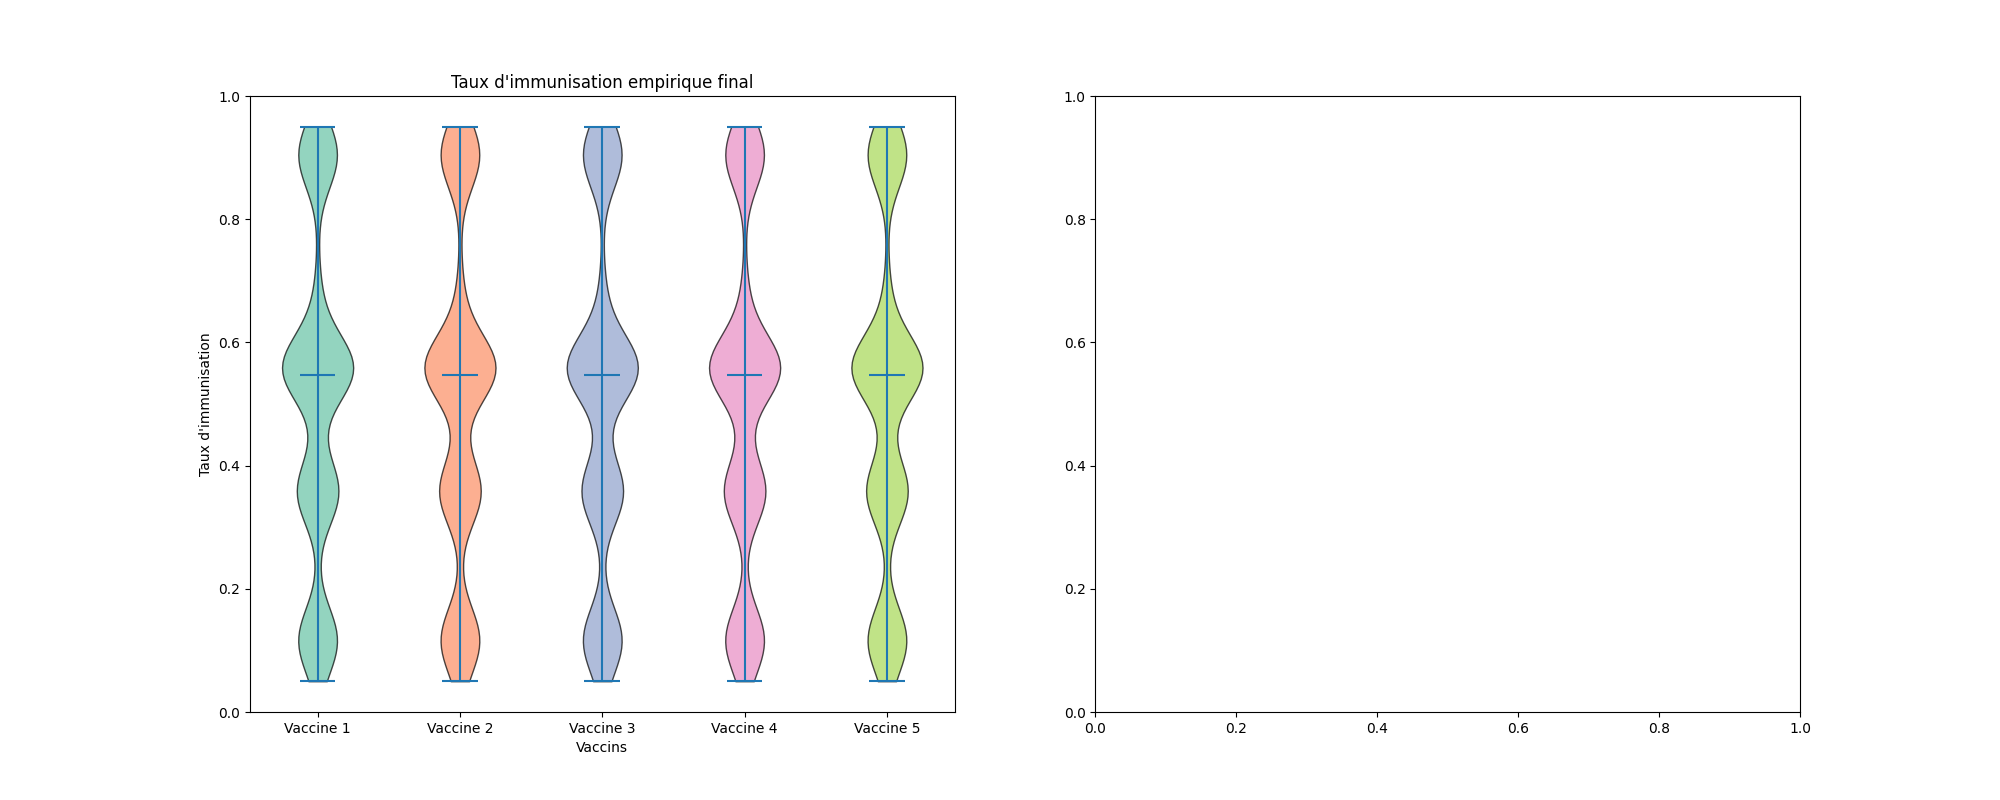

In [9]:
%matplotlib ipympl

def thomson_quick_sampling(N, M):
    MAB = generate_arms(K)
    vacc_betas = [Beta() for _ in range(K)]
    immune_rates = [[]]*K
    rewards = 0
    # EXPLORATION
    for i in range(N):
        arm = i % K
        reward = MAB[arm].sample().item()
        if reward:
            vacc_betas[arm].immuned += 1
        else:
            vacc_betas[arm].non_immuned += 1

        for j, imune_rate in enumerate(immune_rates):
            immune_rates[j].append(vacc_betas[j].immuned / (vacc_betas[j].immuned + vacc_betas[j].non_immuned))

        rewards += reward

    # EXPLOITATION
    for i in range(M):
        vaccin = np.argmax([b.sample() for b in vacc_betas])
        reward = MAB[vaccin].sample()
        if reward:
            vacc_betas[vaccin].immuned += 1
        else:
            vacc_betas[vaccin].non_immuned += 1

        for j, imune_rate in enumerate(immune_rates):
            immune_rates[j].append(vacc_betas[j].immuned / (vacc_betas[j].immuned + vacc_betas[j].non_immuned))
        rewards += reward


    mu_star = get_mu_star(MAB)
    optimal_reward = (N + M) * mu_star.immunity_rate
    regret = optimal_reward - rewards
    return regret, immune_rates

K = 5  # Number of arms
N = 200  # Exploration phase
M = 500  # Exploitation phase
regrets, immune_rates = thomson_quick_sampling(N, M)

# Convert to numpy arrays if they're not already
regrets = np.array(regrets).flatten()  # Ensure it's a 1D numpy array
immune_rates = [np.array(rates) for rates in immune_rates]

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Violin plot for immunization rates
violins = ax1.violinplot(immune_rates, showmeans=False, showmedians=True)

# Customize violin plot
for i, pc in enumerate(violins['bodies']):
    pc.set_facecolor(plt.cm.Set2(i))
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

ax1.set_title('Taux d\'immunisation empirique final')
ax1.set_xlabel('Vaccins')
ax1.set_ylabel('Taux d\'immunisation')
ax1.set_xticks(range(1, K+1))
ax1.set_xticklabels([f'Vaccine {i+1}' for i in range(K)])
ax1.set_ylim(0, 1)

# Plot for regret
ax2.plot(range(N+M), regrets, label='Regret')
ax2.set_title('Evolution du regret')
ax2.set_xlabel('Patients')
ax2.set_ylabel('Regret')
ax2.legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("Final Immunization Rates:")
for i, rates in enumerate(immune_rates):
    print(f"Vaccine {i+1}: Mean = {np.mean(rates):.4f}, Median = {np.median(rates):.4f}")
print(f"\nFinal Regret: {regrets[-1]:.4f}")

*[Ajoutez votre commentaire ici]*

**Q14. Comparez le regret avec les autres algorithmes.**

*[Ajoutez votre commentaire ici]*

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**